本教程基于：   
1、[github扩散模型教程](https://github.com/huggingface/diffusion-models-class)    
2、Hugging Face联名图书《扩散模型从原理到实战》  
3、Hugging Face官方网站diffusers文档及扩散模型相关教程    
4、相关论文  
5、自己的实践

什么是diffusers？  
huggingface推出的扩散模型工具包。  
为什么要学习diffusers？  
1、几行代码快速利用扩散模型生成图像（使用简单）  
2、提供多样的模型和必备组件，构建端到端的扩散模型（快速开发）  

# 第一节 环境安装和hugging face扩散模型演示

## 你将学到什么？
1、环境搭建  
2、hugging face访问  
3、一个基于dreambooth技术微调出的稳定扩散模型示例  

## 1.1 环境搭建

In [2]:
# 设置cuda运算为同步，出问题便于调试观察
# 仅用于测试！！！
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# gpu 版本 pytorch 安装
# 详情见 https://pytorch.org/get-started/locally/
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# 安装 diffusers
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow
# 安装 huggingface-hub 用于和 huggingface 交互
%pip install huggingface-hub
# 其他依赖，自行解决，少什么装什么

<style>
.hidden-comment {
    color: transparent;
    transition: color 0.3s;
}

.hidden-comment:hover {
    color: black;
}
</style>

## 1.2 hugging face访问

In [3]:
# 访问 https://huggingface.co/settings/tokens 生成有 write 权限的 token 用于登录
from huggingface_hub import notebook_login
notebook_login()

# 如果不是 notebook 环境，程序内调用
# from huggingface_hub import login
# login(token="your token", write_permission=True)

# 命令行调用，调用的方法和上面相同只是进行命令行的封装
# huggingface-cli login

## 1.3 一个基于dreambooth技术微调出的稳定扩散模型示例

### 1.3.1 定义图像显示函数

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image

# 给定一批图像，创建一个网格并将其转换为PIL
def show_images(x):
    x = x * 0.5 + 0.5  # 将（-1，1）区间映射回（0，1）区间
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

# 给定一个PIL图像列表，将它们叠加成一行以便查看
def make_grid(images, size=64):
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im
# 对于Mac，可能需要设置成device = 'mps'(未经测试)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 网络不好，可能需要多尝试几次下载
# 一个下载异常重试的装饰器，对于需要下载的模块避免重复写下载异常判断
import functools

def retry_on_exception(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        while True:
            try:
                return func(*args, **kwargs)
            except Exception as e:
                print(e)
    return wrapper

### 1.3.2 使用 diffusers 管线快速加载扩散模型

In [5]:
# 用dreambooth技术微调出的稳定扩散模型示例，土豆人先生
# dreambooth是做什么的
# google开发团队的解释：
# It’s like a photo booth, but once the subject is captured, it can be synthesized wherever your dreams take you.
# 这就像一个照相亭，但一旦拍摄了主体，它就可以在你梦想的任何地方合成。

from diffusers import StableDiffusionPipeline
# https://huggingface.co/sd-dreambooth-library ，这里有来自社区的各种模型
# 该模型仅仅使用了知名儿童玩具“Mr. Potato Head”（土豆先生）的5张照片
model_id = "sd-dreambooth-library/mr-potato-head"

# 加载管线
# 模型下载路径（可选），最好自定义，方便管理和查找
cache_dir = r'E:\model_zoo\huggingface\diffusers\mr-potato-head'

# 用装饰器修饰方法
@retry_on_exception
def load_stable_diffusion_pipeline(model_id, cache_dir, torch_dtype=torch.float32, device='cuda'):
    return StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, cache_dir=cache_dir).to(device)
pipe = load_stable_diffusion_pipeline(model_id, cache_dir, torch_dtype=torch.float16, device=device)

vae\diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### 1.3.3 简单使用，生成自己的土豆先生

  0%|          | 0/50 [00:00<?, ?it/s]

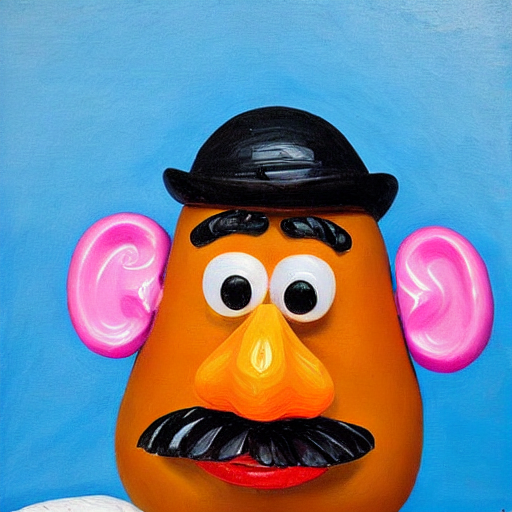

In [6]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

# 删除使用过的管线清空显存占用，cuda有效
# 请务必在实验结束清空显存占用，否则老的模型会一直占用显存影响后续实验
del pipe
torch.cuda.empty_cache()

image

# 第二节 用 pytorch 从零搭建扩散模型

## 你将学到什么？  
1、初步了解扩散模型的工作过程  
2、使用 pytorch 深度学习框架搭建自己的简易扩散模型  

（待完成）

# 第三节 通过蝴蝶图像 DDPM 模型探索 diffusers 管线

## 你将学到什么？
1、diffusers API构成    
2、加载DDPM预设管线  
3、训练自己的扩散模型

## 3.1 diffusers AI构成

Diffusers核心API主要分为三部分。  
● 管线：从高层次设计的多种类函数，旨在便于部署的方式实现，能够快速地利用预训练好的主流扩散模型来生成样本。    
● 模型：在训练新的扩散模型时需要用到的网络结构，如UNet模型。  
● 调度器：在推理过程中使用多种不同的技巧来从噪声中生成图像，同时也可以生成训练过程中所需的“带噪”图像。

## 3.2 加载预设的蝴蝶DDPM管线

对于普通用户，能加载预设好的管线已经足够使用。  
但对于学习教程的读者，应该有深入学习的需求，例如：管线的组成、各组件原理、定义自己的管线等。  
我们先展示如何加载预设的管线，后面再深入学习、实践。  

diffusion_pytorch_model.safetensors not found


  0%|          | 0/1000 [00:00<?, ?it/s]

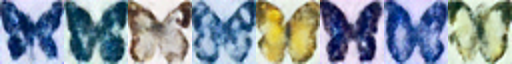

In [7]:
from diffusers import DDPMPipeline

cache_dir = r'E:\model_zoo\huggingface\diffusers\ddpm-butterflies-32px'

@retry_on_exception
def load_ddpm_pipeline(model_id, cache_dir, device):
    return DDPMPipeline.from_pretrained(model_id, cache_dir=cache_dir).to(device)

# 加载预设好的管线
butterfly_pipeline = load_ddpm_pipeline('johnowhitaker/ddpm-butterflies-32px', cache_dir, device)

# 生成8张图片
images = butterfly_pipeline(batch_size=8).images

del butterfly_pipeline
torch.cuda.empty_cache()

# 输出图片
make_grid(images)

## 3.3 训练自己的蝴蝶扩散模型

训练扩散模型的流程如下：  
（1）从训练集中加载图像。  
（2）添加不同级别的噪声。  
（3）将添加了不同级别噪声的数据输入模型。  
（4）评估模型对这些输入去噪的效果。  
（5）使用得到的性能信息更新模型权重，然后重复上述步骤。  

### 3.3.1下载蝴蝶数据集  
下载1000张蝴蝶数据集

In [8]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

cache_dir = r'E:\model_zoo\huggingface\diffusers\smithsonian_butterflies_subset'
@retry_on_exception
def custom_load_dataset(dataset_id, cache_dir, split="train"):
    return load_dataset(dataset_id, cache_dir=cache_dir, split=split)
dataset = custom_load_dataset("huggan/smithsonian_butterflies_subset", cache_dir=cache_dir)
# 也可以从本地文件夹中加载图像
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")
# 我们将在32×32像素的正方形图像上进行训练，但你也可以尝试更大尺寸的图像
image_size = 32
# 如果GPU内存不足，你可以减小batch_size
batch_size = 64
# 定义数据增强过程
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # 调整大小
        transforms.RandomHorizontalFlip(),            # 随机翻转
        transforms.ToTensor(),              # 将张量映射到(0,1)区间
        transforms.Normalize([0.5], [0.5]), # 映射到(-1, 1)区间
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)
# 创建一个数据加载器，用于批量提供经过变换的图像
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Found cached dataset parquet (E:/model_zoo/huggingface/diffusers/smithsonian_butterflies_subset/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


X shape: torch.Size([8, 3, 32, 32])


C:\Users\zyan\AppData\Local\Temp\ipykernel_23852\1687247206.py:4: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)


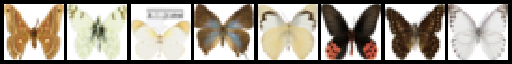

In [9]:
# 输出八张看一下
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

### 3.3.2 调度器  
在训练扩散模型的过程中，我们需要获取这些输入图像并为它们添加噪声，然后将“带噪”的图像输入模型。在推理阶段，我们将使用模型的预测结果逐步消除这些噪声。在扩散模型中，这两个步骤是由调度器（scheduler）处理的。  
噪声调度器能够确定在不同迭代周期分别添加多少噪声。接下来，我们将学习如何使用 DDPM训练和采样的默认设置来创建调度程序（基于论文 “Denoising Diffusion Probabilistic Models”），代码如下：

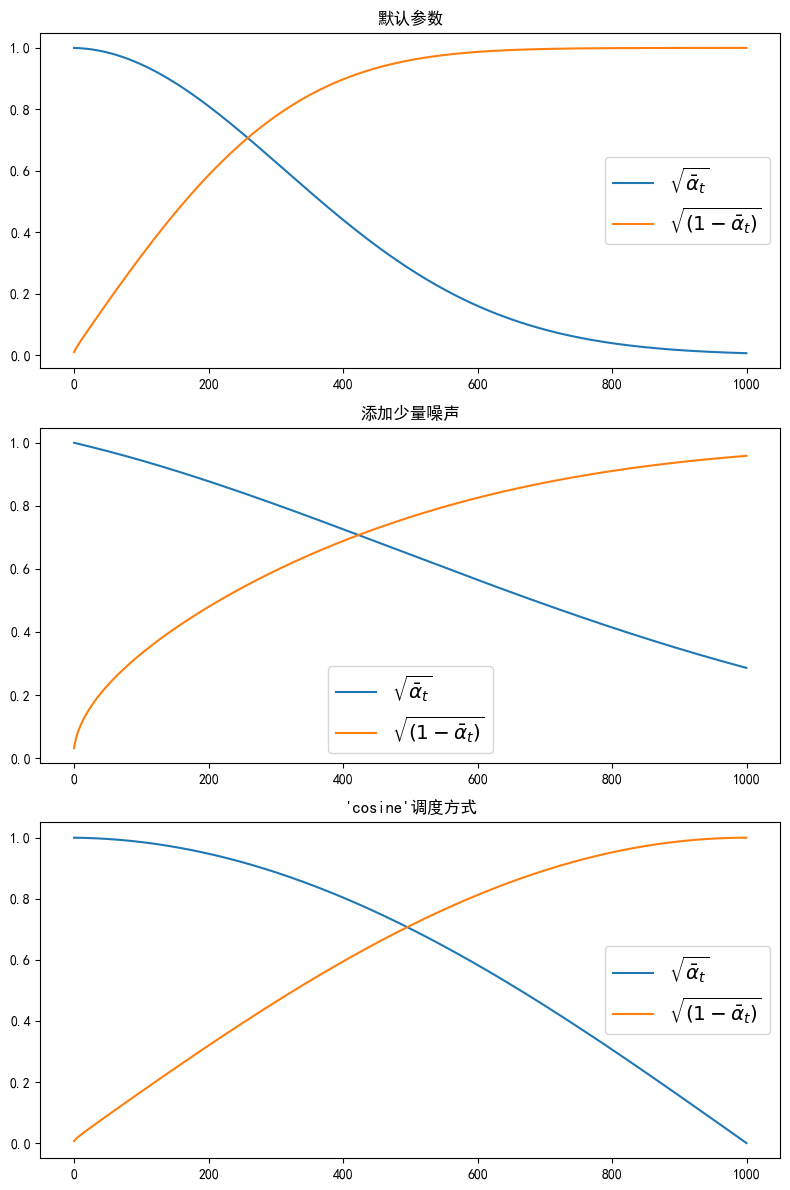

In [10]:
# 我们可以通过设置beta_start、beta_end和beta_schedule 3个参数来控制噪声调度器的超参数beta
# beta_start为控制推理阶段开始时beta的值，beta_end为控制beta的最终值，beta_schedule则可以通过一个函数映射来为模型推理的每一步生成一个beta值

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 为了正常显示负号

from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# 使用 plt.subplots 创建 3 个子图
fig, axes = plt.subplots(nrows=3, figsize=(8, 12))

# 默认参数
axes[0].plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
axes[0].plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
axes[0].legend(fontsize="x-large")
axes[0].set_title("默认参数")

# # 仅添加了少量噪声
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
axes[1].plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
axes[1].plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
axes[1].legend(fontsize="x-large")
axes[1].set_title("添加少量噪声")

# 'cosine'调度方式，这种方式可能更适合尺寸较小的图像
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
axes[2].plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
axes[2].plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
axes[2].legend(fontsize="x-large")
axes[2].set_title("'cosine'调度方式")

plt.tight_layout()
plt.show()

Noisy X shape torch.Size([8, 3, 32, 32])


C:\Users\zyan\AppData\Local\Temp\ipykernel_23852\2011628523.py:7: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)


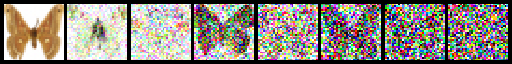

In [11]:
# 对上面抽出来的八张图逐步加噪声观察输出
# 使用上面定义的DDPM调度器执行添加噪声的工作
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

### 3.3.3 定义扩散模型  
大多数扩散模型使用的模型结构是一些UNet模型的变体。  
UNet模型的工作流程如下：  
（1）输入UNet模型的图片会经过几个ResNet层中的标准网络模块，并且在经过每个标准网络模块后，图片的尺寸都将减半。  
（2）同样数量的上采样层则能够将图片的尺寸恢复到原始尺寸。  
（3）残差连接模块会将特征图分辨率相同的上采样层和下采样层连接起来。  
UNet模型的一个关键特征是其输出图片的尺寸与输入图片的尺寸相同，而这正是我们在扩散模型中所需要的。
![unet](./images/unet.jpg)

In [12]:
# 创建扩散模型

from diffusers import UNet2DModel
# 创建模型
model = UNet2DModel(
    sample_size=image_size,   # 目标图像分辨率
    in_channels=3,            # 输入通道数，对于RGB图像来说，通道数为3 
    out_channels=3,           # 输出通道数
    layers_per_block=2,       # 每个UNet块使用的ResNet层数
    block_out_channels=(64, 128, 128, 256), # 更多的通道→更多的参数
    down_block_types=(
        "DownBlock2D",        # 一个常规的ResNet下采样模块
        "DownBlock2D",
        "AttnDownBlock2D",    # 一个带有空间自注意力的ResNet下采样模块
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # 一个带有空间自注意力的ResNet上采样模块
        "UpBlock2D",
        "UpBlock2D",          # 一个常规的ResNet上采样模块
    ),
)
model.to(device);
# 输入上面加噪声的蝴蝶图，查看输出维度是否和输入一致
print(noisy_xb.shape)
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])


torch.Size([8, 3, 32, 32])

### 3.3.4 创建扩散模型训练循环  
这是一个pytorch训练的经典循环。  
每一批数据的训练流程如下：  
（1）随机地采样几个迭代周期。  
（2）对数据进行相应的噪声处理。  
（3）把“带噪”数据输入模型。  
（4）将MSE作为损失函数，比较目标结果与模型的预测结果。在这个示例中，也就是比较真实噪声和模型预测的噪声之间的差距。  
（5）通过调用函数loss.backward()和optimizer.step()来更新模型参数。  
在这个过程中，我们需要记录每一步中损失函数的值，用于后续绘制损失曲线，代码如下：

In [13]:
# 设定噪声调度器
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
# 训练循环
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

# 也可以直接使用管线中的模型，当然前面删除了需要重新加载
# 可以自行对比两者效果
#cache_dir = r'E:\model_zoo\huggingface\diffusers\ddpm-butterflies-32px'
#butterfly_pipeline = load_ddpm_pipeline('johnowhitaker/ddpm-butterflies-32px', cache_dir, device)
#model = butterfly_pipeline.unet

losses = []
for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # 为图片添加采样噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # 为每张图片随机采样一个时间步
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), 
            device=clean_images.device
        ).long()

        # 根据每个时间步的噪声幅度，向清晰的图片中添加噪声
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # 获得模型的预测结果
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # 迭代模型参数
        optimizer.step()
        optimizer.zero_grad()
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

# 如果调用 butterfly_pipeline 需要释放缓存       
#del butterfly_pipeline
#torch.cuda.empty_cache()

E:\ProgramData\Anaconda3\envs\test\lib\site-packages\diffusers\configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.15183352679014206
Epoch:10, loss: 0.11689331196248531
Epoch:15, loss: 0.08918239315971732
Epoch:20, loss: 0.0813963245600462
Epoch:25, loss: 0.08721389342099428
Epoch:30, loss: 0.08390112919732928


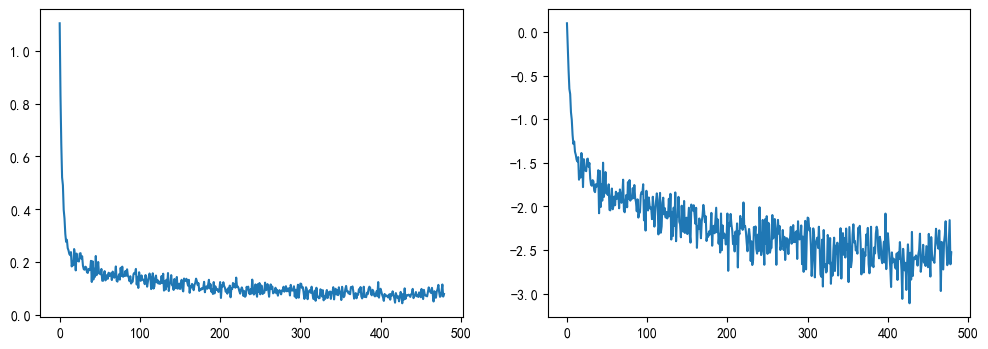

In [14]:
# 绘制损失曲线
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

### 3.3.5 图像的生成  

#### 方法一 建立管线

  0%|          | 0/1000 [00:00<?, ?it/s]

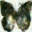

In [15]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]

In [16]:
# 自定义保存文件夹
import json
from pathlib import Path

# 在 windows 平台保存可能会出现问题（其他平台未测试），原因和解决方法如下：
# 如果直接给字符串，Hugging Face 的方法会解析为一个 WindowsPath 对象，WindowsPath对象是不可以直接被JSON序列化的，会报错。
# 我们定义了一个自定义的ExtendedJSONEncoder，它可以处理Path对象（这包括WindowsPath和PosixPath）。然后，我们将其设置为默认的JSON编码器。

# 定义自定义的JSONEncoder来处理WindowsPath
class ExtendedJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Path):
            return str(obj)
        return super().default(obj)

# 设置这个新的JSON编码器为默认编码器
json.JSONEncoder.default = ExtendedJSONEncoder().default

save_dir = r"E:\model_zoo\huggingface\diffusers\my_pipeline"
image_pipe.save_pretrained(save_dir)

del image_pipe
torch.cuda.empty_cache()

#### 方法二 采样循环

时间步： tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 8

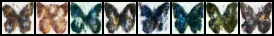

In [22]:
# 随机初始化（8张随机图片）
print("时间步：", noise_scheduler.timesteps)
sample = torch.randn(8, 3, 32, 32).to(device)
for i, t in enumerate(noise_scheduler.timesteps):

    # 获得模型的预测结果
    with torch.no_grad():
        residual = model(sample, t).sample

    # 根据预测结果更新图像
    sample = noise_scheduler.step(residual, t, sample).prev_sample

del model
del noise_scheduler
torch.cuda.empty_cache()

show_images(sample)

# 思考：为什么时间步是从大到小？
# 回答：因为我们在时间上其实是倒退的，整个过程是从高噪声到低噪声的（与前向扩散过程相反）。prev_sample 意为 previous sample 很好地说明这一点。

# 第四节 微调和引导

In [ ]:
## 你将学到什么？  
1、 
2、

（待完成）

In [18]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
# 这次要探索的管线比较多
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
)
# 因为要用到的展示图片较多，所以我们写了一个旨在下载图片的函数
@retry_on_exception
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")
# Inpainting需要用到的图片
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

In [19]:
# 载入管线
model_id = "stabilityai/stable-diffusion-2-1-base"
cache_dir = r'E:\model_zoo\huggingface\diffusers'
# 如果显存不足请指定revision="fp16",torch_dtype=torch.float16
@retry_on_exception
def load_stable_diffusion_pipeline(model_id, cache_dir, torch_dtype=torch.float32, device='cuda'):
    return StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, cache_dir=cache_dir).to(device)

pipe = load_stable_diffusion_pipeline(model_id, cache_dir, device=device)

vae\diffusion_pytorch_model.safetensors not found


In [20]:
# 注意力切分功能，降低速度减少GPU占用
# pipe.enable_attention_slicing()

  0%|          | 0/50 [00:00<?, ?it/s]

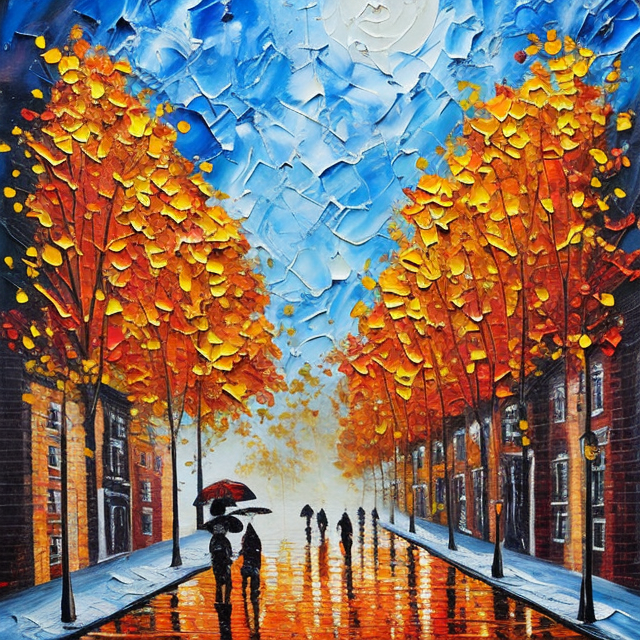

In [21]:
# 给生成器设置一个随机种子，这样可以保证结果的可复现性
generator = torch.Generator(device=device).manual_seed(42)
# 运行这个管线
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",
    # 提示文字：哪些要生成
    negative_prompt="Oversaturated, blurry, low quality",
    # 提示文字：哪些不要生成
    height=640, width=640,     # 定义所生成图片的尺寸
    guidance_scale=8,          # 提示文字的影响程度
    num_inference_steps=50,    # 定义一次生成需要多少个推理步骤
    generator=generator        # 设定随机种子的生成器
)
# 查看生成结果
pipe_output.images[0]

In [22]:
# 主要的调节参数如下：
# ● width和height用于指定所生成图片的尺寸，注意它们必须是能被8整除的数字，因为只有这样，VAE才能正常工作（原因稍后介绍）。
# ● 步数num_inference_steps也会影响所生成图片的质量，采用默认设置50即可，你也可以尝试将其设置为20并观察效果。
# ● negative_prompt用于强调不希望生成的内容，这个参数一般在无分类器引导的情况下使用。这种添加额外控制的方式特别有效：
#    列出一些不想要的特征，以帮助生成更好的结果。
# ● guidance_scale 决定了无分类器引导的影响强度。增大这个参数可以使生成的内容更接近给出的文本提示语；
#    但如果该参数过大，则可能导致结果过于饱和，不美观。

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

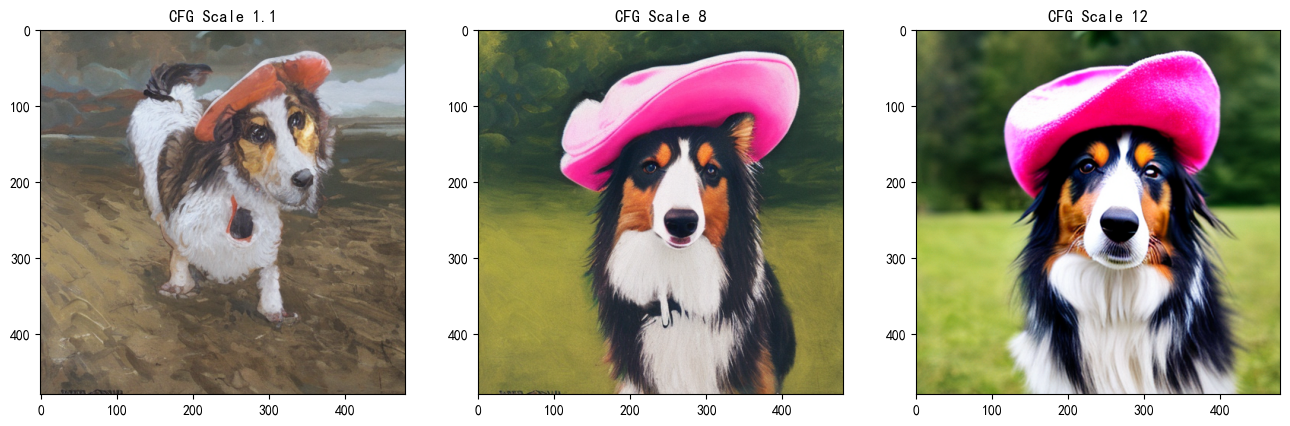

In [23]:
# 加大guidance_scale参数的作用
cfg_scales = [1.1, 8, 12] 
prompt = "A collie with a pink hat" 
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(prompt, height=480, width=480, 
              guidance_scale=cfg_scales[i], num_inference_steps=35, 
              generator=torch.Generator(device=device).manual_seed(42)).images[0] 
    ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}')
    
# 一般来说 guidance_scale 在 8-12 是不错的选择

In [24]:
# Stable Diffusion Pipeline

In [25]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


In [26]:
# VAE（可变分自编码器）

# 创建取值区间为(-1, 1)的伪数据
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)
# 编码到隐空间
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)
# 再解码回来
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [27]:
# 分词器和文本编码器

# 手动对提示文字进行分词和编码
# 分词
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")
# 将分词结果输入CLIP 
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
    print("Text embeddings shape:", text_embeddings.shape)

# 输出最终编码结果
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, False, '')
print(text_embeddings.size())

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])
torch.Size([1, 77, 1024])


In [28]:
# UNet

# 创建伪输入
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)
# 让模型进行预测
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


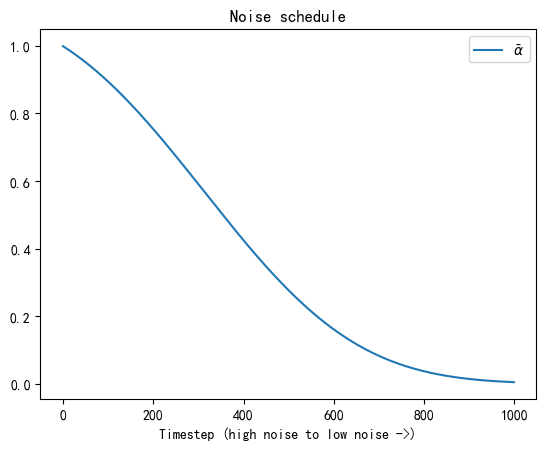

In [29]:
# 调度器
# 调度器保存了关于如何添加噪声的信息，并管理如何基于模型的预测更新“带噪”样本。
# 默认调度器是 PNDMScheduler，也可以使用其他调度器如 LMSDiscreteScheduler

# 观察采样过程中噪声的变化
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)')
plt.title('Noise schedule')
plt.legend()

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.16.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}


  0%|          | 0/50 [00:00<?, ?it/s]

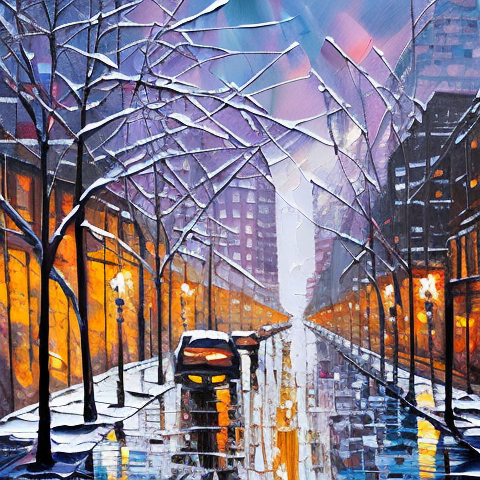

In [30]:
from diffusers import LMSDiscreteScheduler
# 替换原来的调度器
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
# 输出配置参数
print('Scheduler config:', pipe.scheduler)
# 使用新的调度器生成图片
pipe(prompt="Palette knife painting of an winter cityscape", 
     height=480, width=480, generator=torch.Generator(device=device).manual_seed(42)).images[0]

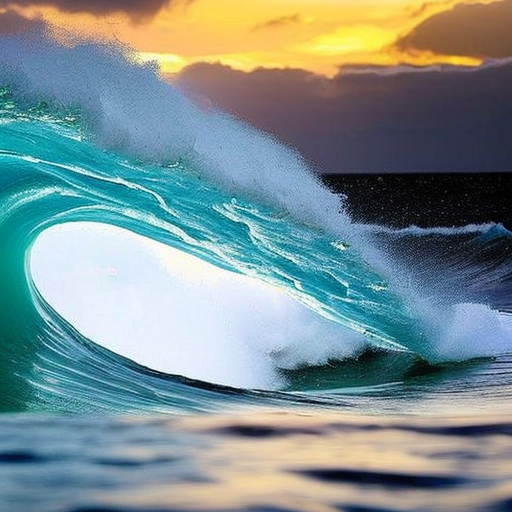

In [33]:
guidance_scale = 8
num_inference_steps=30
prompt = "Beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, oversaturated, warped"

# 对提示文字进行编码
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)
# 创建随机噪声作为起点
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma
# 准备调度器
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
# 生成过程开始
for i, t in enumerate(pipe.scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
# 将隐变量映射到图片
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

pipe.numpy_to_pil(image)[0]

In [ ]:
# 其他pipeline介绍